# Topic 8 - FX Carry Trade

## FINM 36700: Portfolio and Risk Management

### Mark Hendricks

#### Autumn 2023

In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings

from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

import sys
sys.path.insert(0, '../cmds')
from treasury_cmds import *
from portfolio import *

$$\newcommand{\frn}{*}$$

$$\newcommand{\RF}{R^{f,\$}}$$
$$\newcommand{\RFa}{R^{f,\frn}}$$

$$\newcommand{\rflog}{\texttt{r}^{f,\$}}$$
$$\newcommand{\rfalog}{\texttt{r}^{f,\frn}}$$

$$\newcommand{\Fcrncy}{F^{\$}}$$
$$\newcommand{\fcrncylog}{\texttt{f}^{\$}}$$

$$\newcommand{\FX}{S}$$
$$\newcommand{\fxlog}{\texttt{s}}$$

# Data

In [2]:
DATAPATH_FX = '../data/fx_carry_data.xlsx'
SHEET = 'fx rates'
fx = pd.read_excel(DATAPATH_FX, sheet_name=SHEET).set_index('DATE')

USDRF = 'USD'
SHEET = 'risk-free rates'
rfraw = pd.read_excel(DATAPATH_FX,sheet_name=SHEET).set_index('DATE')
rfraw.columns = [col.removesuffix('1M') for col in rfraw.columns]
rfusd = rfraw[[USDRF]]
rf = rfraw.drop(columns=[USDRF])

fxgrowth = (fx / fx.shift())
rets = fxgrowth.mul(1+rf.values,axis=1) - 1
rx = rets.sub(rfusd.values,axis=1)

In [3]:
logFX = np.log(fx)
logRFraw = np.log(rfraw+1)
logRFusd = logRFraw[[USDRF]]
logRF = logRFraw.drop(columns=[USDRF])

logRFspread = -logRF.subtract(logRFusd.values,axis=0)
logRFspread = logRFspread.shift(1)

logFXgrowth = logFX.diff(axis=0)

logRX = logFXgrowth - logRFspread.values

# The Carry Trade

The carry trade logic is simple:
* go long the currency with the higher interest rate.
* hope that future currency depreciation does not offset the gain from the interest-rate differential.

Empirically, what happens?

## Historically

Historically, the excess return on the carry trade has been significant.
* A widely-used trading strategy.
* At times presented like an arbitrage, it is not.
* If there is systematic risk in FX volatility, then it is a premium for this exposure.

Even so, potentially attractive in that the risk premium is not explained by obvious factors like market beta.

## Peso problems
As is seen in the picture, the carry trade is subject to large crashes. Referred to as a “peso problem”.
* In the 1970’s, Mexico had pegged their FX rate to the USD for over a decade.
* Yet, a significant interest rate differential persisted.
* Seemingly a lucrative trade: higher interest rate, no FX
volatility.
* But what about risk of infrequent, sudden, and large depreciation?

In fact, there eventually was a large depreciation of the peso.

## Carry Trade and Options?

Given that exchange rates are subject to large sudden movements,
* Carry trade premium is similar to writing far out of the money puts.
* Make a consistent, small premium, but subject to big losses in a catastrophe.
* But some research shows that even after hedging extreme movements with options, the carry trade has excess returns.

What economic factors explain this premium?

# Testing the Carry Trade

Run a forecasting regression for the log FX Growth, as implied by UIP.
- UIP implies that the interest rate spread is the optimal predictor of FX growth.
- Thus, it implies the forecasting beta should be 1.

## Linearization

This relationship is easier to analyze in a linear form. Taking logs,

$$\ln\mathbb{E}_t\left[\FX_{t+1}\right] - \fxlog_t = \rflog_{t+1} - \rfalog_{t+1}$$

## Regression Tests

Consider the regression tests for these two UIP statements. 
1. Using the interest rate differential,

$$\fxlog_{t+1} - \fxlog_t = \alpha + \beta\left(\rflog_{t+1} - \rfalog_{t+1}\right) + \epsilon_{t+1}$$

(Noting yet again that $\rflog_{t+1}$ is known at time $t$.) 

2. Alternatively, using the forward premium,
$$\fxlog_{t+1} - \fxlog_t = \alpha + \beta\left(\fcrncylog_{t} - \fxlog_{t}\right) + \epsilon_{t+1}$$

In either test, UIP implies that $\beta=1, \alpha=0$.

In [4]:
olstab = pd.DataFrame(index=logFXgrowth.columns, columns=['alpha','Beta','r-squared'])
for i, curncy in enumerate(logFXgrowth.columns):
    temp = get_ols_metrics(logRFspread.iloc[:,i],logFXgrowth.iloc[:,i],annualization=1).drop(columns=['Treynor Ratio','Info Ratio'])
    temp.rename(columns={logRFspread.columns[i]:'Beta'}, inplace=True)
    olstab.loc[curncy,:] = temp.values

olstab.T

,USUK,USEU,USSZ,USJP
alpha,-0.000489,0.000586,0.003631,-0.0005
Beta,0.485836,-1.256358,-1.646596,0.371473
r-squared,0.000382,0.00261,0.003948,0.000501


### Predicting Appreciation or Depreciation?

Look at whether the betas are positive or negative.

If the regressor (USD minus foreign risk-free rate) goes DOWN, then we expect 
- decreased UK and JP relative to US.
- increased EU and SZ relative to US. (That is, the expected FX growth is higher.)

Thus, if UK risk-free rate increases relative to US risk-free rate, we expect USD will appreciate.
- This means FX growth is partially offsetting the interest-rate differential. But not fully. Beta is positive, but less than one.

For EU and SZ,
- this means that FX growth is exacerbating the returns from the interest rate differentials. Beta is negative, so in a sense, investors expect to gain twice: immediately from the risk-free rate differential, and again from the FX movement at the close of the position.

In fact, the statements above are just about the point estimates, and may not be statistically significant.

### Strength of Predictability?
These effects are extremely small! The R-squared stats for all four currencies are nearly 0. 

# The Dynamic Carry Trade

In [11]:
forecast = pd.DataFrame(columns=logFXgrowth.columns, index=logFXgrowth.index)
for i, curncy in enumerate(logFXgrowth.columns):
    forecast[curncy] = olstab.loc[curncy,'alpha'] + (olstab.loc[curncy,'Beta']-1) * logRFspread.iloc[:,i]

### Forecast timing
We do not need to lag the forecasts with `.shift()` because we already use the lagged calculation of the interest rate spread. 

Thus, the regressor is lagged, and thus is generating forecasts stamped with the date of their targeted value, as desired.

In [6]:
forecast_positive = ((forecast.dropna() > 0).sum() / forecast.dropna().shape[0]).to_frame().T
forecast_positive.index = ['fraction with positive forecastium']
forecast_positive

,USUK,USEU,USSZ,USJP
fraction with positive forecastium,0.238095,0.501832,0.630037,0.0


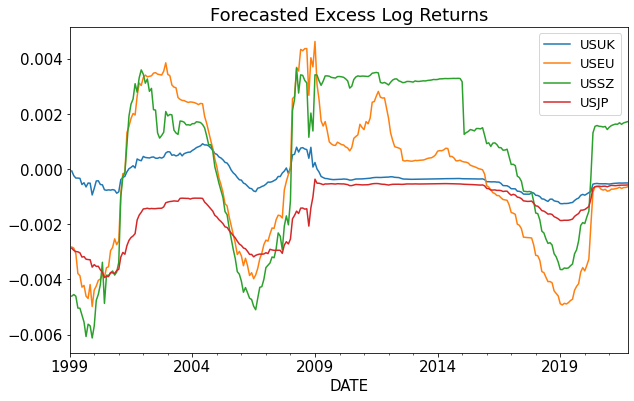

In [7]:
forecast.plot(title='Forecasted Excess Log Returns', figsize=(10,6));

#### Positive or Negative Forecasts?

Though the static carry-trade above found that UK and EU have negative mean excess (log) returns, the dynamic carry trade finds that the time-varying forecast is often positive.

For JP, the forecast is negative throughout the sample due to the much higher interest rate in USD not being offset by appreciation of the Yen to the USD.

#### Improving the Trade?

We can use forecasts of excess returns to construct trading positions, (weights,) which vary with the forecasts. The resulting trading strategy should be better than the static carry trade.

That is, we could time the magnitude and direction of the currency trades instead of being passively 100\% invested in a currency according to the evidence above.

It is analagous to timing the trading of SPY according to the Earnings-Price Ratio instead of being passively 100\% invested in SPY.

Of course, it is an open question as to whether this will work given the weak R-squared in-sample, let alone out-of-sample.

# Building the Dynamic Trade

Try implementing the forecasts with a simple proportional weighting of each forecast.

In [12]:
passive = logRX
forecast_baseline = logRX.expanding().mean().shift(1)

wts = 100 * forecast
forecast_returns = wts * passive.values

## Check the performance

#### Also compare to the equally-weighted combination of the currency trades

All stats are **much** better than the static carry trade.
- But this is an in-sample performance.
- Open question whether the OOS version can beat the static table.

Note that currencies have low means and low vols, so in no case are we expecting to get equity-like return statistics.

In [9]:
forecast_returns['Equally-Weighted'] = forecast_returns.mean(axis=1) * 10

performanceMetrics(forecast_returns,annualization=12)

,Mean,Vol,Sharpe,Min,Max
USUK,0.000419,0.004990,0.084020,-0.006025,0.004872
USEU,0.007638,0.024128,0.316560,-0.037816,0.034689
USSZ,0.010005,0.028341,0.353011,-0.037256,0.025738
USJP,0.003722,0.016532,0.225130,-0.022019,0.021783
Equally-Weighted,0.054459,0.135583,0.401669,-0.168438,0.148568


### How correlated are the active (forecasted) implementations to the passive returns?

- Not all that correlated.
- Note that we're interested in the magnitude, not the sign.
- The active version is shorting JP, so no surprise that the correlation is negative.

In [10]:
corr_tab = forecast_returns.corrwith(passive,drop='missing',axis=0).to_frame().T
corr_tab.index = ['Corr. Passive to Active']
corr_tab

,USUK,USEU,USSZ,USJP
Corr. Passive to Active,-0.396114,0.260195,0.377176,-0.810576
